In [105]:
# Load the needed package
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import cmath
from scipy.fft import fft, fftfreq, ifft
from scipy.signal import find_peaks

from scipy.integrate import solve_ivp
from decimal import *
from tqdm import tqdm

In [106]:
# Load the parameters first 
# All in SI
# 2, 0.1 30
wrf = 2 * np.pi* 10e9 # 10 GHz
wmm = 2 * np.pi* 10e9 # 10 GHz
wradical = 2 * np.pi * 1e9 # 2 GHz  
waxial = 2 * np.pi * 300e6 # 300 MHz
deff = 200e-6 # 200 micron
m = 9.10938297e-31 # 9.10938297e-31 kg 
q = 1.6e-19 # 1.6e-19 C

# Here are the tank circuit
Rp = 1e7
Q = 2000
#fres = 1000e7 convlution
fres = 0

kB = 1.380649e-23 # Boltzman constant, given by Wikipedia
Temperature = 0.4 # Temperature for the tank circuit, given by article

# Define the spatial step size and the time step size

dt = 1e-12 # time step size
T = 1e-6 # total time
N = round(T/dt)

t_eval = np.linspace(0, T, N + 1)

N_segment = 40
Amplifier_Num_init = 1
# Motion initialization

x0, y0, z0, vx0, vy0, vz0 = 10e-6, 10e-6, 5e-6, 1., 1., 1.
Vec0 = x0, y0, z0, vx0, vy0, vz0

progress_bar = tqdm(total=T, desc='Simulated time (s)', position=0, leave=True)

Simulated time (s):  52%|█████▏    | 5.220669999954585e-07/1e-06 [02:07<01:56, 243342555.93s/it]


In [107]:
def Vdc(Vec, t):
    x, y, z, vx, vy, vz = Vec
    return 1/4/q * m * waxial ** 2* (2 * z ** 2 - x ** 2 - y ** 2)

def Vrf(Vec, t):
    x, y, z, vx, vy, vz = Vec
    return m * wradical * wrf * np.sqrt(2) / q * np.cos(wrf * t) * (x ** 2- y ** 2) /2

def Edc(Vec, t):
    x, y, z, vx, vy, vz = Vec
    A = 1/2/q * m * waxial ** 2
    return A * x, A * y, -2 * A * z

def Erf(Vec, t):
    x, y, z, vx, vy, vz = Vec
    A = m * wradical * wrf * np.cos(wrf * t) * np.sqrt(2) / q
    return A * (- x), A * y, 0.

def noise_on_trap(U_rms, samplerate, samples, R, fres, bandwidth = 1e7):
    t = np.linspace(0, samples / samplerate, int(samples))
    
    signal = np.random.normal(0, bandwidth, size = len(t))
    X = np.fft.fft(signal)
    N = len(X)
    freqs = np.fft.fftfreq(N) * samplerate
    freqs[0] = 1e-5
    f_U_noise = U_rms * X / ( 1 +  1j * R * (freqs / fres - fres / freqs))
    U_noise = np.fft.ifft(f_U_noise)
    return np.real(U_noise)

# Calculate motional deviation according to Edc and Erf
def DevMotion_init(t, Vec):
    x, y, z, vx, vy, vz = Vec
    Ex, Ey, Ez = tuple(map(sum, zip(Edc(Vec, t),
                                    Erf(Vec, t))))
    ax = q * Ex / m
    ay = q * Ey / m
    az = q * Ez / m
    progress_bar.update(dt)
    return vx, vy, vz, ax, ay, az

def DampingForce_test(Vec_init, Vec, t):
    global Damping_Ex_Ampl
    global fres
    x_init, y_init, z_init, vx_init, vy_init, vz_init = Vec_init
    x, y, z, vx, vy, vz = Vec
    #DampingFactor_tlist.append(t)
    
    if abs(vx / vx_init) > 10 or abs(vx_init) < 1e-6:
        #DampingFactor_list.append(10)
        #return 0., 0.,0.
        if vx / vx_init > 0:
            return Damping_Ex_Ampl * 10 * np.sin(2 * np.pi * fres * t), 0., 0.
        if vx / vx_init < 0:
            return - Damping_Ex_Ampl * 10 * np.sin(2 * np.pi * fres * t), 0., 0.

    #DampingFactor_list.append(vx / vx_init)
    return Damping_Ex_Ampl * vx / vx_init * np.sin(2 * np.pi * fres * t + phase), 0., 0.

#Calculate the JN noise of the circuit
def JNNoise(Vec, t):
    posi = int(t/dt * Amplifier_Num_init)

    return JNNoise_Ex[posi] + (JNNoise_Ex[posi + 1] - JNNoise_Ex[posi]) * (t/dt * Amplifier_Num_init - posi), 0., 0.
    #return 0., 0., 0.

def DevMotion_para(t, Vec_para):
    
    x_init, y_init, z_init, vx_init, vy_init, vz_init, x, y, z, vx, vy, vz = Vec_para
    Vec_init = x_init, y_init, z_init, vx_init, vy_init, vz_init
    Vec = x, y, z, vx, vy, vz
    Ex, Ey, Ez = tuple(map(sum, zip(Edc(Vec, t),
                                    Erf(Vec, t),
                                    DampingForce_test(Vec_init, Vec, t),
                                    #JNNoise(Vec, t)
                                    )))
    ax = q * Ex / m
    ay = q * Ey / m
    az = q * Ez / m

    Ex_init, Ey_init, Ez_init = tuple(map(sum, zip(Edc(Vec_init, t),
                                                   Erf(Vec_init, t),
                                                  )))
    ax_init = q * Ex_init / m
    ay_init = q * Ey_init / m
    az_init = q * Ez_init / m
    progress_bar.update(dt)
    return vx_init, vy_init, vz_init, ax_init, ay_init, az_init, vx, vy, vz, ax, ay, az

In [108]:
x_final = np.array([])
y_final = np.array([])
z_final = np.array([])
vx_final = np.array([])
vy_final = np.array([])
vz_final = np.array([])

for iter in range(N_segment):
    # Using RK45 to solve the ODE
   
    # initial simulation
    Vec0 = x0, y0, z0, vx0, vy0, vz0
    T_init = 1e-6
    t_eval_init = np.linspace(iter * T, iter * T + T_init, Amplifier_Num_init * (round(T_init/dt) + 1))
    solution = solve_ivp(fun=lambda t, Vec: DevMotion_init(t, Vec), 
                         t_span = (iter * T, iter * T + T_init), 
                         y0 = Vec0, 
                         t_eval = t_eval_init, 
                         first_step = dt / Amplifier_Num_init,
                         max_step = dt / Amplifier_Num_init,
                         atol = 1e1,
                         rtol = 1e1,
                         method = 'RK45')
    t_init = solution.t
    VecResult_init = solution.y
    x_init, y_init, z_init = VecResult_init[0, :], VecResult_init[1, :], VecResult_init[2, :]
    vx_init, vy_init, vz_init = VecResult_init[3, :], VecResult_init[4, :], VecResult_init[5, :]
    progress_bar.close()

    # FFT on the initial velocity
    vxf_init = fft(vx_init)
    vyf_init = fft(vy_init)
    vzf_init = fft(vz_init)
    tf = fftfreq(len(vx_init), dt / Amplifier_Num_init)

    Front = 0
    Cutoff = 4
    vf = vxf_init[Front:Front + (vxf_init.size//Cutoff//2)]
    ttf = tf[:len(vx_init)//2]
    ttf = ttf[Front:Front + (ttf.size//Cutoff)]

    # Get normalized magnitude of specturm
    N_vf_init = 2.0/(Amplifier_Num_init * (N+1)) * np.abs(vf[0:len(vx_init)//2])


    # use find_peaks to get all the peaks
    peaks, _ = find_peaks(N_vf_init, height=0)


    # we only need the three largest peaks, therefore we find a border and find peaks again
    temp = N_vf_init[peaks]
    temp.sort()
    temp = temp[::-1]
    border = ( temp[3] + temp[2])/2
    
    peaks, heights = find_peaks(N_vf_init, height= border)

    # define the resonator's frequency
    fres = ttf[peaks[2]]

    tf[0] = 1e-5

    Rezf = Rp / (1 + Q ** 2 * (tf / fres - fres / tf) ** 2)
    Imzf = Rp *  Q  * (tf / fres - fres / tf) / (1 + Q ** 2 * (tf / fres - fres / tf) ** 2)
    Rezf = np.array(Rezf)
    Imzf = np.array(Imzf)
    zf = Rezf + 1j * Imzf

    # This is for multiply of the spectrum
    Damping_Exf = np.multiply(vxf_init, zf)

    Damping_Ex_t = np.real(ifft(Damping_Exf))
    Damping_Ex = list(Damping_Ex_t.real)
    # An additional general -1 should be added, because this is damping force
    Damping_Ex =[- q / deff ** 2 * a for a in Damping_Ex]
    Damping_Ex_Ampl = (abs(max(Damping_Ex)) + abs(min(Damping_Ex))) / 2
    phase = np.arcsin(Damping_Ex[0] / Damping_Ex_Ampl)
    # Generate the JNNoise to be added into the simulation
    U_rms = np.sqrt(4 * kB * Temperature * Rp * Amplifier_Num_init / dt)

    JNNoise_Ex = 1 / deff * noise_on_trap(U_rms= U_rms, samplerate= Amplifier_Num_init / dt, samples= 1.05 * T / dt * Amplifier_Num_init, R = Rp, fres = fres)
    JNNoise_Ey = 1 / deff * noise_on_trap(U_rms= U_rms, samplerate= Amplifier_Num_init / dt, samples= 1.05 * T / dt * Amplifier_Num_init, R = Rp, fres = fres)
    JNNoise_Ez = 1 / deff * noise_on_trap(U_rms= U_rms, samplerate= Amplifier_Num_init / dt, samples= 1.05 * T / dt * Amplifier_Num_init, R = Rp, fres = fres)

    # Setting the process bar with tqdm
    progress_bar = tqdm(total=T, desc='Simulated time (s)', position=0, leave=True)
    # Using RK45 to solve the ODE
    Amplifier_Num = 1

    t_eval = np.linspace(iter * T, iter * T + T, Amplifier_Num * (N + 1))

    # This is for damping factor and time domain method
    Vec0 = x0, y0, z0, vx0, vy0, vz0, x0, y0, z0, vx0, vy0, vz0

    solution = solve_ivp(fun=lambda t, Vec: DevMotion_para(t, Vec), 
                        t_span = (iter * T, iter * T + T), 
                        y0 = Vec0, 
                        t_eval = t_eval, 
                        first_step = dt,
                        max_step = dt,
                        atol = 1e1,
                        rtol = 1e1,
                        method = 'RK45')

    t_damp = solution.t
    VecResult = solution.y

    x_damp, y_damp, z_damp = VecResult[6, :], VecResult[7, :], VecResult[8, :]
    vx_damp, vy_damp, vz_damp = VecResult[9, :], VecResult[10, :], VecResult[11, :]
    progress_bar.close()

    x0 = x_damp[-1]
    y0 = y_damp[-1]
    z0 = z_damp[-1]
    vx0 = vx_damp[-1]
    vy0 = vy_damp[-1]
    vz0 = vz_damp[-1]
    
    # get the final array
    
    x_final = np.append(x_final, x_damp[:-1])
    y_final = np.append(y_final, y_damp[:-1])
    z_final = np.append(z_final, z_damp[:-1])
    vx_final = np.append(vx_final, vx_damp[:-1])
    vy_final = np.append(vy_final, vy_damp[:-1])
    vz_final = np.append(vz_final, vz_damp[:-1])

t_final = np.linspace(0, T * N_segment, N_segment * Amplifier_Num * (N + 1))

Simulated time (s): 100%|█████████▉| 9.999680000086502e-07/1e-06 [00:34<00:00, 32287557.12s/it] /Users/mac/Library/Python/3.9/lib/python/site-packages/tqdm/std.py:533: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
Simulated time (s): 600%|██████████| 6.000001000205529e-06/1e-06 [03:24<-1:57:10, 34034533.87s/it] 
Simulated time (s): 600%|██████████| 6.000001000205529e-06/1e-06 [04:07<-1:56:34, 41231494.11s/it]  
Simulated time (s): 600%|██████████| 6.000001000205529e-06/1e-06 [04:12<-1:56:30, 42140542.99s/it]  


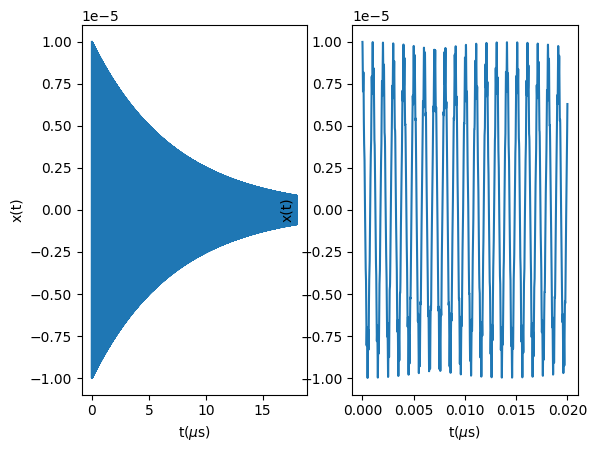

In [ ]:
# Plot the x-axis motion
fig1, ax = plt.subplots(1,2)

# Plot the data on the axes
ax[0].plot(np.array(t_final[:len(x_final) // 500 * 500])*1e6, x_final[:len(x_final) // 500 * 500])
#ax[0].plot(np.array(t_eval[:len(x_damp)])*1e6, x_damp[:len(x_damp)])

# Add labels to the axes
ax[0].set_xlabel('t($\mu$s)')
ax[0].set_ylabel('x(t)')

# Plot the data on the axes
Zoomnum = round(0.02e-6/dt)
ax[1].plot(np.array(t_final[:Zoomnum // 1 * 1])*1e6, x_final[:Zoomnum])

# Add labels to the axes
ax[1].set_xlabel('t($\mu$s)')
ax[1].set_ylabel('x(t)')


# Show the plot
plt.show()

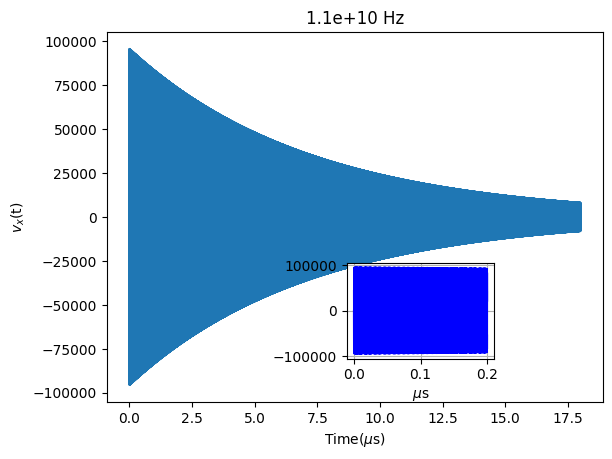

In [ ]:
plt.plot(t_final[:len(x_final)]*1e6, vx_final[:len(x_final)])
#ax[0].plot(np.array(t_eval[:len(x_damp)])*1e6, x_damp[:len(x_damp)])

# Add labels to the axes

plt.xlabel('Time($\mu$s)')
plt.ylabel('$v_x$(t)')

#plt.ylim([-2e8, 2e8])
plt.title('{:.2} Hz'.format(fres))
Zoomnum = round(0.2e-6/dt)
x_zoom = np.array(t_final[:Zoomnum // 1 * 1])*1e6
y_zoom = vx_final[:Zoomnum]
axes = plt.axes([.50, .2, .23, .2])
axes.plot(x_zoom, y_zoom, c='blue', lw=1, label='Zoomed curve')
axes.set_xlabel('$\mu$s')
#axes.legend(‘right’)

plt.grid()
#plt.legend()
plt.show()

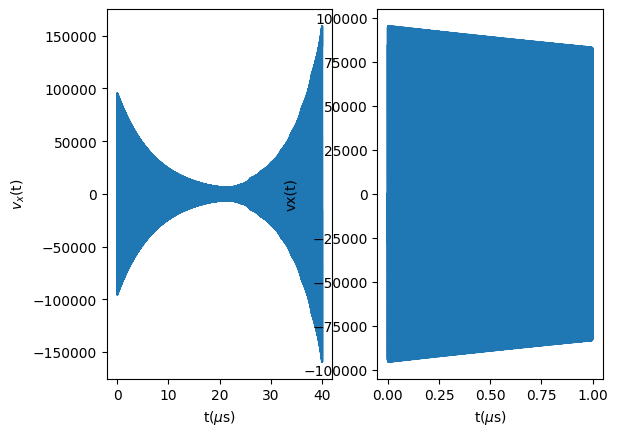

In [ ]:
# Plot the x-axis motion
fig1, ax = plt.subplots(1,2, sharey= False)

# Plot the data on the axes
ax[0].plot(np.array(t_final[:len(x_final) // 500 * 500])*1e6, vx_final[:len(x_final) // 500 * 500])
#ax[0].plot(np.array(t_eval[:len(x_damp)])*1e6, x_damp[:len(x_damp)])

# Add labels to the axes
ax[0].set_xlabel('t($\mu$s)')
ax[0].set_ylabel('$v_x$(t)')

# Plot the data on the axes
Zoomnum = round(1e-6/dt)
ax[1].plot(np.array(t_final[:Zoomnum // 25 * 25])*1e6, vx_final[:Zoomnum // 25 * 25])

# Add labels to the axes
ax[1].set_xlabel('t($\mu$s)')
ax[1].set_ylabel('vx(t)')

# Show the plot
plt.show()

In [ ]:
print('cooling time for secular = {} us'.format(m * deff ** 2/ q ** 2/ Rp * 1e6))

cooling time for secular = 0.14233410890625003 us
